# Bayesian Model Fitting in Python with emcee
## *Computational Research Day 2018 Workshop*


***
By AM Geller and AA Miller <br/>
April 10, 2018

Today we will focus on a seemingly simple problem: fitting a straight line to data.

Though we've all done this before, we've probably at some point oversimplified the analysis or at least not fully understood all the assumptions that went into our analysis. 

This workshop is inspired by the paper [Data Analysis Recipes: Fitting a Model to Data](https://arxiv.org/abs/1008.4686) by Hogg, Bovy, & Lang. If you haven't already read this paper, I ***highly*** recommend it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.optimize import minimize
import pickle

import emcee
import corner

#%matplotlib notebook
%matplotlib inline

np.random.seed(seed=2222)
ncores = 6 # adjust this to match your machine

The first thing we need is the data.  Let's start with a prepared data set from that paper.  Later we can move to a real data set (maybe your own).

In this data set, you'll notice that each $\left(x,y\right)$ point has an uncertainty characterized by a guassian with variance $\left(\sigma_x^, \sigma_y^2\right)$, while there is also covariance between the $x$ and $y$ measurements described by a correlation coefficient $\rho_{xy}$.  I found [this nice 1-page info sheet online](http://www.cs.utah.edu/~tch/CS4300/resources/refs/ErrorEllipses.pdf) if you want a further reference.

The full uncertainty covariance matrix for each data point is given by:

$$S_i = \left[ {\begin{array}{cc}
        \sigma_{xi}^2 & \rho_{xyi}\sigma_{xi}\sigma_{yi} \\
        \rho_{xyi}\sigma_{xi}\sigma_{yi} & \sigma_{yi}^2  \\
        \end{array}
       }
       \right] 
       $$

In [2]:
obs_x = np.array([203., 58., 210., 202., 198., 158., 
                165., 201., 157., 131., 166., 160., 
                186., 125., 218., 146.])
obs_y = np.array([495., 173., 479., 504., 510., 416., 
                393., 442., 317., 311., 400., 337., 
                423., 334., 533., 344.])
sigma_x = np.array([5., 9., 4., 4., 11., 7., 
                    5., 5., 5., 6., 6., 5., 
                    9., 8., 6., 5.])
sigma_y = np.array([21., 15., 27., 14., 30., 16., 
                    14., 25., 52., 16., 34., 31., 
                    42., 26., 16., 22.])
rho_xy = np.array([-0.33, 0.67, -0.02, -0.05, -0.84, -0.69,
                    0.30, -0.46, -0.03, 0.50, 0.73, -0.52, 
                    0.90, 0.40, -0.78, -0.56])

Let's plot the data.

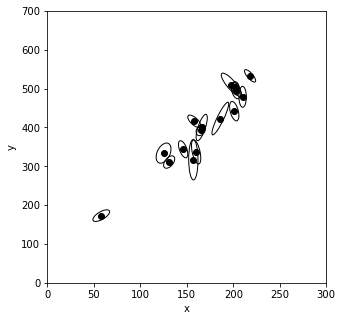

In [3]:
def plotData(ax, x, y, xerr, yerr, rhoxy, zorder = 10):
    ax.scatter(x, y, color = 'black', zorder = 10)
    for (xx, yy, sx, sy, rxy) in zip(x,y,xerr, yerr, rhoxy):
        cov = np.array([[ sx**2, rxy*sx*sy],
                        [rxy*sx*sy, sy**2.]])
        w, v  = np.linalg.eig(cov)
        theta = np.arctan(2. * rxy * sx * sy / (sx**2. - sy**2.))/2.
        ax.add_artist(Ellipse((xx, yy), 2.*w[0]**0.5, 2.*w[1]**0.5, \
                              angle = np.rad2deg(theta),\
                              facecolor="none", edgecolor="black", zorder = zorder))
        
f, ax = plt.subplots(1, figsize = (5,5))
plotData(ax, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax.set_xlim(0,300)
ax.set_ylim(0,700)
ax.set_xlabel('x')
ax.set_ylabel('y')

Now, let's fit the line :

$y = mx + b$.  

How would you do this?

Probably the first attempt would be some kind of least squares optimization ... but ...

A standard assumption of the least-squares method is that the independent variable (typically $x$) is measured with perfect precision. Thus, standard least squares cannot account for the uncertainties on both $x$ and $y$ (simultaneously).  As a demonstration of ***WHAT NOT TO DO*** (but is sometimes attempted), here's an example of a "forward-reverse" fitting procedure, where you first fit by ignoring $\sigma_x$ then do the inverse and ignore $\sigma_y$.  

I repeat ***DO NOT DO THIS*** for a real publication.  This is only to illustrate a point.

The best-fit value for the ('forward') slope and intercept are: 2.2399 +/- 0.1345 and 34.0477 +/- 22.7656
The best-fit value for the ('reverse') slope and intercept are: 2.6352 +/- 0.2753 and -49.9429 +/- 44.4360


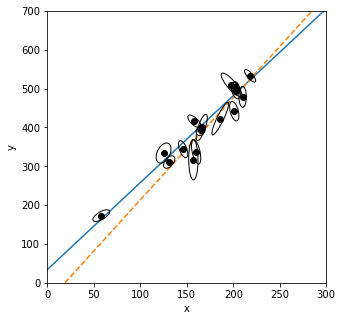

In [4]:
f, ax = plt.subplots(1, figsize = (5,5))
plotData(ax, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax.set_xlim(0,300)
ax.set_ylim(0,700)
ax.set_xlabel('x')
ax.set_ylabel('y')

#"abominable" forward–reverse fitting procedure
#DON'T DO THIS!
#polyfit with uncertainties on y ("forward")
p_xy, pcov = np.polyfit(obs_x, obs_y, 1, w = 1./sigma_y, cov = True)
err_xy = np.sqrt(np.diag(pcov))
p_xy_eval = np.poly1d(p_xy)
print("The best-fit value for the ('forward') slope and intercept are: {:.4f} +/- {:.4f} and {:.4f} +/- {:.4f}"\
      .format(p_xy[0], err_xy[0], p_xy[1], err_xy[1]))
ax.plot([0,300],p_xy_eval([0,300]),color='C0')

#polyfit with uncertainties on x ("reverse")
p_yx, pcov = np.polyfit(obs_y, obs_x, 1, w = 1./sigma_x, cov = True)
err_yx = np.sqrt(np.diag(pcov))
p_yx_eval = np.poly1d(p_yx)
inv = [1./p_yx[0], -p_yx[1]/p_yx[0]]
inv_err = [inv[0]**2.*err_yx[0],  (p_yx[0]**-2 * err_yx[1]**2. + (p_yx[1]/p_yx[0]**2.)**2. * err_yx[0]**2.)**0.5]
print("The best-fit value for the ('reverse') slope and intercept are: {:.4f} +/- {:.4f} and {:.4f} +/- {:.4f}"\
      .format(inv[0], inv_err[0], inv[1], inv_err[1]))
ax.plot(p_yx_eval([0.,700.]), [0.,700.],'--',color='C1')

mFreq = p_xy[0]
bFreq = p_xy[1]


Again ***DO NOT DO THIS IN A PUBLICATION***. 

It should be fairly obvious why you don't want to do this.  For instance, 
- The results (at least for the intercept) are not in agreement, given the uncertainties on the parameters
- How would you combine these results to give some meaningful answer?
- Do you actually trust the uncertainties on these parameters?  Are the parameter uncertainties actually symmetric?
- Most importantly, neither method actually accounts for both uncertainties or their correlation coefficients ($\rho_{xy}$).

Least-squares fitting reduces to some linear algebra. [See the Hogg, Bovy, & Lang paper referenced above for the derevation of these relations.]

Below we demonstrate the same results as `np.polyfit()` above.

In [5]:
#a little bit more thorough and returns the same result as the "forward" fit
Y = obs_y.reshape(-1,1)
A = np.vstack((np.ones_like(obs_x), obs_x)).T
C = np.diag(sigma_y**2)

X = np.linalg.inv(A.transpose()@np.linalg.inv(C)@A) @ (A.transpose()@np.linalg.inv(C)@Y)

best_fit = np.poly1d(X[::-1,0])
print("The best-fit value for the slope and intercept are: {:.4f} and {:.4f}".format(X[1][0], X[0][0]))

The best-fit value for the slope and intercept are: 2.2399 and 34.0477


OK.  The naive first attempt is not appropriate for this problem.  That least squares fitting makes certain assumptions (e.g., that the $x$ uncertainties are negligible).  Let's relax those assumptions and frame the problem more generally.

First, some statistics... (Some of you may enjoy this, others may not.  It's OK if you don't fully understand all of this today.  We will get to the `emcee` fitter very soon.)

## Minimizing $\chi^2$

A common procedure taught in undergraduate lab classes to minimize "chi squared" in order to identify the "best-fit" parameters $m$ and $b$: 

$$ \chi^2 = \Sigma_{i = 1}^{N} \frac{\left[y_i - f(x_i)\right]^2}{\sigma_{y_i}^2},$$

where $f(x) = mx + b$ is the model for the data. 

A least-squares fit, such as the ones used above, minimizes the value of $\chi^2$, which in turn provides a "best-fit" estimate of $m$ and $b$.

## Maximizing the Likelihood

Alternatively, we could consider a generative model, in which case the probability of any observation $y_i$ is dependent on $x_i$, our model $f(x)$, and some scatter associated with the measurement itself $\sigma_{yi}$:

$$ p\left(y_i\, | \, x_i, \sigma_{yi}, f(x_i) \right) = \frac{1}{\sqrt{2\pi\sigma_{y_i}^2}}\,\exp\left(-\frac{\left[y_i - f(x_i)\right]^2}{2\,\sigma_{y_i}^2} \right).$$

An alternative to $\chi^2$ minimization is to maximize the probability of the observed data given the model, which is to say we want to maximize the *likelihood of the observed data given the model*. We can write the likelihood function $\mathscr{L}$ as the product of the conditional probability of every observation:

$$ \mathscr{L} = \prod_{i=1}^{N} p\left(y_i\, |\, x_i, \sigma_i, f(x_i) \right)$$

This product is often difficult to evaluate, so we often take the logarithm of the likelihood, and maximize that. In this care we get:

$$ \ln \mathscr{L} = K - \sum_{i=1}^{N} \frac{\left[y_i - f(x_i) \right]^2.}{2\sigma_{yi}^2} 
   = K - \frac{1}{2}\chi^2 $$
   
where $K$ is some constant. As you can see, maximizing the likelihood (in this case) is equivalent to minimizing $\chi^2$.

Note: an important assumption in all of this is that the uncertainties, $\left(\sigma_x, \sigma_y\right)$, are Gaussian.  This is usually a reasonable assumption.

When maximizing the likelihood we can get a "pretty good" estimate of the model parameters, $m$ and $b$. This estimate is only "pretty good" because Thomas Bayes is rolling in his grave. Bayes' theorem tells us about conditional probability distributions:

$$ p\left(\theta\, |\, X, I\right) = \frac{p\left(X\, |\, \theta, I\right) p\left(\theta\, |\, I\right)}{p\left(X\, |\, I\right)} $$

In words, we want to know the (*posterior*) probability distribution for the parameters $\theta$, which $= (m,b)$ in this case, given the data $X$ and any prior knowledge $I$, $p\left(\theta\, |\, X, I\right)$.  

$p\left(X\, |\, \theta, I\right)$ is the *likelihood*, and has been defined above.  

$p\left(\theta\, |\, I\right)$ is the "*prior*" probability distribution for the parameters, that contains all of our knowledge of what those parameters should be (this can come from physical models or previous experiments).  

The denominator can be thought of as a normalization constant that most people ignore (and we will also ignore it).

Ok.  That's very nice.  

But how do we actually use all this math??!!  

And, hey, you said this was a workshop about emcee!

In [6]:
# compute the log likelihood
def lnlike(theta, x, y, yerr):
    m, b = theta
    model = m * x + b
    ln_l = np.sum( np.log( 1./np.sqrt(2*np.pi *sigma_y**2.) * np.exp(-0.5*((y - model)/sigma_y)**2) ) )
    
    return ln_l.squeeze()

# compute the log prior
def lnprior(theta):
    m, b = theta
    if ( (0 < m < 10) and (-200 < b < 200) ):
        return 0.0
    return -np.inf

# compute the log of the likelihood multiplied by the prior
def lnprob(theta, x, y, yerr):
    lnp = lnprior(theta)
    lnl = lnlike(theta,  x, y, yerr)
    if (not np.isfinite(lnp) or not np.isfinite(lnl)):
        return -np.inf
    return lnp + lnl


Now, as a check, let's try to maximize this likelihood with scipy and confirm that we get the same results as the least-squares procedure described above (actually we'll minimize the negative log likelihood as this is an easier computational task).

In [7]:
def ilnlike(theta, x, y, yerr):
    lnl = -lnlike(theta, x, y, yerr)
    return lnl.squeeze()

guess0 = np.array([2.*np.random.random() * mFreq, 2.*np.random.random() * bFreq])
scFit = minimize(ilnlike, guess0, args=(obs_x, obs_y, sigma_y))
print(scFit.message)
print("The initial guess for the slope and intercept are: {:.4f} and {:.4f}"\
      .format(guess0[0], guess0[1]))
print("The best-fit value for the slope and intercept are: {:.4f} and {:.4f}".format(scFit.x[0], scFit.x[1]))


Optimization terminated successfully.
The initial guess for the slope and intercept are: 3.2577 and 19.6786
The best-fit value for the slope and intercept are: 2.2399 and 34.0475


## *emcee*

Now, let's use *[emcee](http://dfm.io/emcee/current/)*, a pure-Python implementation of [Goodman & Weare’s Affine Invariant Markov chain Monte Carlo (MCMC) Ensemble sampler](https://msp.org/camcos/2010/5-1/p04.xhtml) written by [Dan Foreman-Mackey](http://dfm.io/).

We've already spent enough time on background, so I will let you read about MCMC on your own (e.g., [here's the wikipedia entry](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)).  You may also want to read [this journal article about emcee](https://arxiv.org/abs/1202.3665).

In short, we can use *emcee* to sample the posterior distribution that is defined by a Bayesian likelihood and priors (using MCMC).  *emcee* will use a number of "walkers" to explore this parameter space, each working their way toward the maximum of the likelihood function (while accounting for the priors).  The combination of the paths that each of these walkers take, i.e. their "chains", define the posterior distribution, and provide us with probability distributions for each of the model parameters.

In [8]:
nwalkers = 100
nfac = [1e-2, 1e-2]
ndim = len(guess0)
pos = [guess0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(obs_x, obs_y, sigma_y), threads = ncores)

nsamples = 2000
foo = sampler.run_mcmc(pos, nsamples)


And now let's explore the output

In [9]:
# set a "burn-in" limit
nburn = 200
m_samples = np.array(sampler.chain[:,nburn:,0]).flatten()
b_samples = np.array(sampler.chain[:,nburn:,1]).flatten()

#print the results taking 1-sigma confidence intervals
samples = np.vstack([m_samples, b_samples]).T
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      m = {:.4f} +{:.4f} -{:.4f}\n \
      b = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(m_mcmc[0], m_mcmc[1], m_mcmc[2], b_mcmc[0], b_mcmc[1], b_mcmc[2]))

emcee results with 1-sigma uncertainties
       m = 2.2406 +0.1069 -0.1087
       b = 34.0366 +18.2444 -18.2746



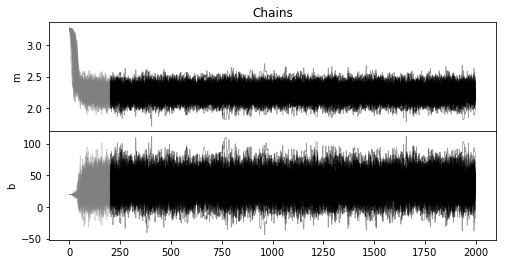

In [10]:
#some function to make plots (will re-use them later)
#to plot the chains
def plotChains(sampler, nburn, paramsNames):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams,1, figsize = (8,2*Nparams), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = range(len(sampler.chain[0,:,0]))

    for i,p in enumerate(paramsNames):
        for w in range(sampler.chain.shape[0]):
            ax[i].plot(xplot[:nburn], sampler.chain[w,:nburn,i], color="0.5", alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.chain[w,nburn:,i], color="k", alpha = 0.4, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            
    return ax

paramsNames = ['m','b']

axC = plotChains(sampler, nburn, paramsNames)

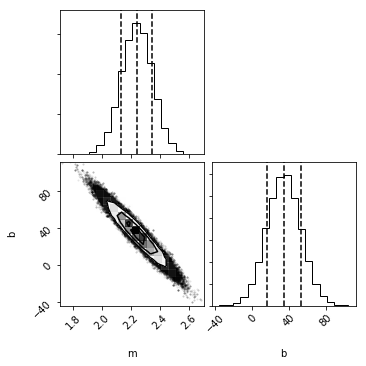

In [11]:
#corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84]):
    samples = sampler.chain[:, nburn:, :].reshape((-1, len(paramsNames)))
    f = corner.corner(samples, labels = paramsNames, quantiles = quantiles)

makeCorner(sampler, nburn, paramsNames)

(0, 700)

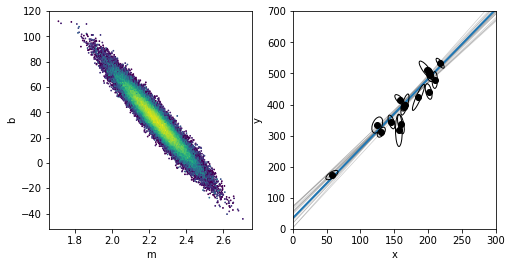

In [12]:
#Adam's plots
def prettyPlot(x, y, xerr, yerr, rhoxy, m_samples, b_samples, m, b, nburn, ndraw = 20, extent = None):
    fig, ax = plt.subplots(1,2, figsize = (8,4))
    ax[0].set_xlabel("m")
    ax[0].set_ylabel("b")
    ax[1].set_xlabel("x")    
    ax[1].set_ylabel("y")

    ax[0].hexbin(m_samples[nburn:], b_samples[nburn:], gridsize = 250,  mincnt = 1, bins = "log", extent = extent)

    plotData(ax[1], x, y, xerr, yerr, rhoxy)
    ax[1].plot([0,300], [b + 0*m, b + 300*m], lw = 2, zorder = 2)
    for rand_draw in np.random.randint(nburn, len(m_samples), ndraw):
        m_draw = m_samples[rand_draw]
        b_draw = b_samples[rand_draw]
        ax[1].plot([-1e10,1e10], [b_draw + -1e10*m_draw, b_draw + 1e10*m_draw],
                 color = "0.5", alpha = 0.4, lw = 0.7, zorder = 1)

    return ax


axA = prettyPlot(obs_x, obs_y, sigma_x, sigma_y, rho_xy, m_samples, b_samples, m_mcmc[0], b_mcmc[0], nburn, ndraw = 20)
axA[1].set_xlim(0,300)
axA[1].set_ylim(0,700)

OK.  But... didn't we just get the same result as before? 

And, didn't you start this workshop talking about how we need to account for the uncertainties on $x$ as well?

## Uncertainties on both axes

To also account for the uncertainties on the $x$ variable, we need do define a new likelihood function.  We've gone through a lot of statistics already, so, for the sake of time, we'll breeze through this.  Look at the Hogg paper for more details.

If we assume the uncertainties are Gaussian (as we are doing), we can write the probability for obtaining a measurement, 

$$ Z_i = \left[ {\begin{array}{c}
        x_i \\
        y_i \\
        \end{array}
       }
       \right] 
$$

when the "true value" (the value you would have this data point if it had been observed with negligible noise is:

$$ Z = \left[ {\begin{array}{c}
        x \\
        y \\
        \end{array}
       }
       \right] 
$$

as 

$$ p\left(x_i, y_i\, |\, S_i, x,y\right) = \frac{1}{2\pi \sqrt{\det(S_i)}} \exp\left(-\frac{1}{2}\left[Z_i - Z\right]^T S_i^{-1} \left[Z_i - Z\right]\right) $$

But how do we use this to fit a line?  (What should we use for Z?)  The "trick" is to project the 2D uncertainties onto the sub-space that is orthogonal to the line and to evaluate the projected displacements.  This will involve a change in variables from $(m, b)$ to $(\theta, b_\perp)$, as follows:

$$
\begin{align}
\theta &= \arctan m \\
b_\perp &= b \cos \theta \\
\hat{v} &= \left[ {\begin{array}{c}
        -\sin \theta \\
        \cos \theta \\
        \end{array}
       }
       \right] \\
\Delta_i &= \hat{v}\, Z_i - b_\perp \\
\Sigma_i^2 &= \hat{v}^T\, S_i\, \hat{v} \\
\ln \mathscr{L} &= K - \sum_{i=1}^{N} \frac{\Delta_i^2}{2\Sigma_i^2} \\
\end{align}
$$

In short, $\Delta_i$ is the orthogonal displacement of each data point $(x_i, y_i)$from the line, and $\Sigma^2$ is the orthogonal variance (by projecting the covariance matrix $S_i$, which we defined previously).

Whew!  Let's see that in action.

In [13]:
def lnlike2(theta, x, y, xerr, yerr, rhoxy):
    th, bperp = theta
    lnl = 0.
    v = np.array([[-np.sin(th)], [np.cos(th)]])
    vT = v.transpose()
    for (xx, yy, sx, sy, rxy) in zip(x, y, xerr, yerr, rhoxy):
        S = np.array([[ sx**2, rxy*sx*sy],
                    [rxy*sx*sy, sy**2.]]) 
        Z = np.array([[xx],[yy]])
        Delta = vT @ Z - bperp
        Sigma2 = vT @ S @ v
        #lnl += (np.log( 1./(2.*np.pi * Sigma2)) - Delta**2. / (2. * Sigma2)) #this gives a slightly different result
        lnl -= Delta**2. / (2. * Sigma2) #this ignores the constant K but gives the same result as in the Hogg paper
        
    return lnl#.squeeze()

def lnprior2(theta):
    th, bperp = theta
    if ( (0 < np.abs(th) < 2.*np.pi) and (-200 < bperp < 200)):
        return 0.0
    return -np.inf

def lnprob2(theta, x, y, xerr, yerr, rhoxy):
    lnp = lnprior2(theta)
    lnl = lnlike2(theta,  x, y, xerr, yerr, rhoxy)
    if (not np.isfinite(lnp) or not np.isfinite(lnl)):
        return -np.inf
    return lnp + lnl

def thFromM(m):
    return np.arctan(m)
def bpFromBth(b, th):
    return b * np.cos(th)
def mFromTh(th):
    return np.tan(th)
def bFromThBp(th, bp):
    return bp/np.cos(th)

## Exercise:

Run this probability distribution through *emcee*, then print and plot the results.


In [14]:
nwalkers = 100
nfac = [1e-2, 1e-2]
th = thFromM(mFreq)
bp = bpFromBth(bFreq, th)
guess0 = np.array([th, bp])

ndim = len(guess0)
pos = [guess0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy), threads = ncores)

nsamples = 2000
foo = sampler.run_mcmc(pos, nsamples)

In [15]:
# set a "burn-in" limit
nburn = 200
th_samples = np.array(sampler.chain[:,nburn:,0]).flatten()
bp_samples = np.array(sampler.chain[:,nburn:,1]).flatten()
m_samples = mFromTh(th_samples)
b_samples = bFromThBp(th_samples, bp_samples)

#print the results taking 1-sigma confidence intervals
samples = np.vstack([m_samples, b_samples]).T
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      m = {:.4f} +{:.4f} -{:.4f}\n \
      b = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(m_mcmc[0], m_mcmc[1], m_mcmc[2], b_mcmc[0], b_mcmc[1], b_mcmc[2]))

emcee results with 1-sigma uncertainties
       m = 2.1944 +0.1228 -0.1138
       b = 36.6880 +18.5641 -19.8081



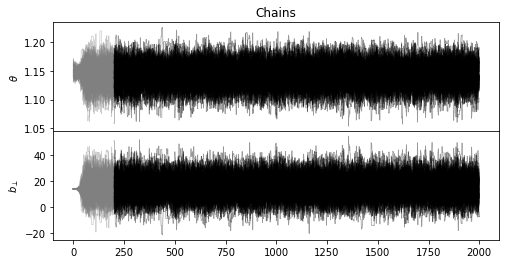

In [16]:
paramsNames = [r'$\theta$', r'$b_\perp$']

#chain plot
axC = plotChains(sampler, nburn, paramsNames)

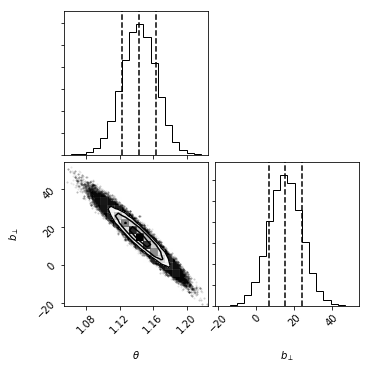

In [17]:
#corner plot
makeCorner(sampler, nburn, paramsNames)

(0, 700)

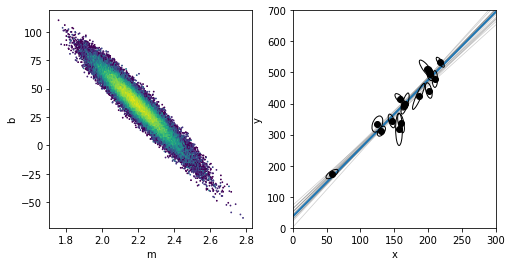

In [18]:
#Adam's plots
axA = prettyPlot(obs_x, obs_y, sigma_x, sigma_y, rho_xy, m_samples, b_samples, m_mcmc[0], b_mcmc[0], nburn, ndraw = 20)
axA[1].set_xlim(0,300)
axA[1].set_ylim(0,700)

So far we haven't really showcased the power of Bayesian model fitting.  One example of when you would really want to use a Baysian tool is when you have model parameters that you want to marginalize over.  The following examples dive into this. 

We will first increase the scatter of our data by adding a few outliers.


## Instrinsic Scatter

Let's assume that the data is still best described by a line, and we think the best fit solution is what we found above (without the extra scatter).  

In [19]:
obs_x = np.append(obs_x, np.array([201., 244., 287.]))
obs_y = np.append(obs_y, np.array([592., 401., 402.]))
sigma_x = np.append(sigma_x, np.array([9., 4., 7.])) 
sigma_y = np.append(sigma_y, np.array([61., 25., 15.]))
rho_xy = np.append(rho_xy, np.array([-0.84, 0.31, -0.27]))

## Exercise:

Use our previous likelihood function with scipy.minimize to fit these data.  Print and plot the results.


Desired error not necessarily achieved due to precision loss.
The best-fit value for the slope and intercept are: 1.6876 and 97.7171


Text(0,0.5,'y')

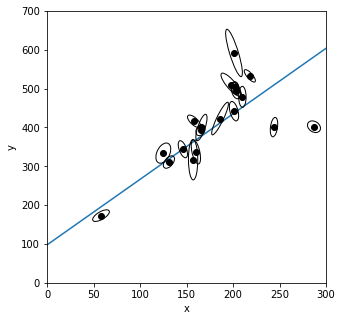

In [20]:
def ilnlike(theta, x, y, xerr, yerr, rhoxy):
    lnl = -lnlike2(theta.squeeze(), x, y, xerr, yerr, rhoxy)
    return lnl

scFit = minimize(ilnlike, guess0, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy))
print(scFit.message)
mSci = mFromTh(scFit.x[0])
bSci = bFromThBp(scFit.x[0], scFit.x[1])
print("The best-fit value for the slope and intercept are: {:.4f} and {:.4f}".format(mSci, bSci))

f, ax = plt.subplots(1, figsize = (5,5))
plotData(ax, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax.plot( [0.,700.], mSci*np.array([0.,700.]) + bSci, color='C0')
ax.set_xlim(0,300)
ax.set_ylim(0,700)
ax.set_xlabel('x')
ax.set_ylabel('y')

The fit is different, clearly pulled by the outliers.  Both fit parameters are $>3\sigma$ away from what we found previously.   Also, notice that (at least on my notebook) the minimize function is giving an ominous warning.  (I would not want to publish the result of that fit!)

But we can deal with this using a slightly different likelihood function, and using *emcee*.  We will introduce one additional variable, $V$ : Gaussian variance orthogonal to the line.  Hogg et al. give us the likelihood:

$$
\ln \mathscr{L} = K - \sum_{i=1}^{N}\frac{1}{2}\ln\left(\Sigma_i^2 + V\right) - \sum_{i=1}^{N} \frac{\Delta_i^2}{2\left[\Sigma_i^2 + V\right]} 
$$

## Exercise:

Code this up into a new likelihood, prior and posterior probability distribution.  Run this through *emcee*.  Print and plot the results.  In your plot that includes the fit line(s), also show the "$1\sigma$" range in the scatter. 


In [21]:
#incorporates intrinsic scatter
def lnlikeS(theta, x, y, xerr, yerr, rhoxy):
    th, bperp, scatter = theta
    lnl = 0.
    v = np.array([[-np.sin(th)], [np.cos(th)]])
    vT = v.transpose()
    for (xx, yy, sx, sy, rxy) in zip(x, y, xerr, yerr, rhoxy):
        S = np.array([[ sx**2, rxy*sx*sy],
                    [rxy*sx*sy, sy**2.]]) 
        Z = np.array([[xx],[yy]])
        Delta = vT @ Z - bperp
        Sigma2 = vT @ S @ v
        lnl -= (0.5 * np.log(Sigma2 + scatter**2.) + Delta**2. / (2. * ( Sigma2 + scatter**2.))) #this ignores the constant K but gives the same result as in the Hogg paper
        
    return lnl#.squeeze()

def lnpriorS(theta):
    th, bperp, scatter = theta
    if ( (0 < np.abs(th) < 2.*np.pi) and (-200 < bperp < 200) and (0 <= scatter < 100)):
        return 0.0
    return -np.inf

def lnprobS(theta, x, y, xerr, yerr, rhoxy):
    lnp = lnpriorS(theta)
    lnl = lnlikeS(theta,  x, y, xerr, yerr, rhoxy)
    if (not np.isfinite(lnp) or not np.isfinite(lnl)):
        return -np.inf
    return lnp + lnl

def thFromM(m):
    return np.arctan(m)
def bpFromBth(b, th):
    return b * np.cos(th)
def mFromTh(th):
    return np.tan(th)
def bFromThBp(th, bp):
    return bp/np.cos(th)

In [22]:
nwalkers = 100
nfac = [1e-2, 1e-2, 1.]
th = thFromM(mFreq)
bp = bpFromBth(bFreq, th)
guess0 = np.array([th, bp, 30.])
ndim = len(guess0)
pos = [guess0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobS, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy), threads = ncores)

nsamples = 2000
foo = sampler.run_mcmc(pos, nsamples)

In [23]:
# set a "burn-in" limit
nburn = 200
th_samples = np.array(sampler.chain[:,nburn:,0]).flatten()
bp_samples = np.array(sampler.chain[:,nburn:,1]).flatten()
s_samples = np.array(sampler.chain[:,nburn:,2]).flatten()
m_samples = mFromTh(th_samples)
b_samples = bFromThBp(th_samples, bp_samples)

#print the results taking 1-sigma confidence intervals
samples = np.vstack([m_samples, b_samples, s_samples]).T
m_mcmc, b_mcmc, s_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      m = {:.4f} +{:.4f} -{:.4f}\n \
      b = {:.4f} +{:.4f} -{:.4f}\n \
      s = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(m_mcmc[0], m_mcmc[1], m_mcmc[2], b_mcmc[0], b_mcmc[1], b_mcmc[2], s_mcmc[0], s_mcmc[1], s_mcmc[2]))

emcee results with 1-sigma uncertainties
       m = 2.3582 +0.7939 -0.4994
       b = -16.5263 +91.1700 -143.5431
       s = 33.3550 +7.8132 -5.9047



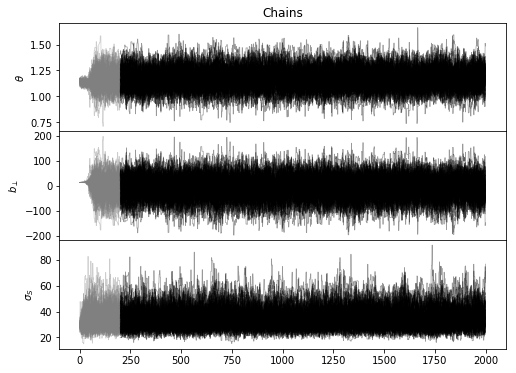

In [24]:
paramsNames = [r'$\theta$', r'$b_\perp$', r'$\sigma_S$']

#chain plot
axC = plotChains(sampler, nburn, paramsNames)

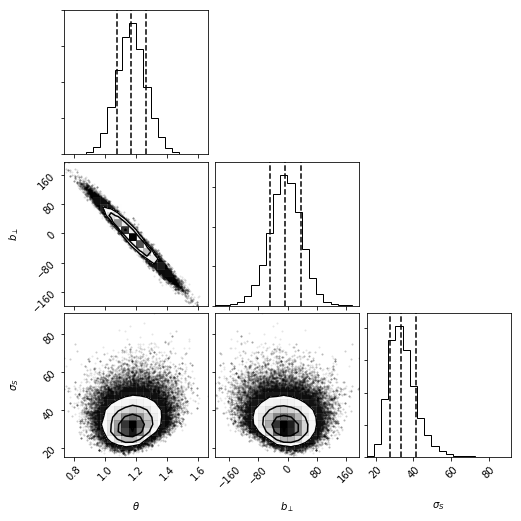

In [25]:
#corner plot
makeCorner(sampler, nburn, paramsNames)

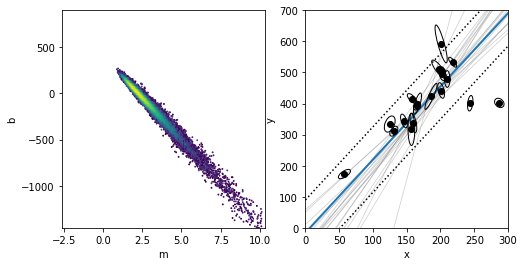

In [26]:
#Adam's plots
fac = 10.
axA = prettyPlot(obs_x, obs_y, sigma_x, sigma_y, rho_xy, m_samples, b_samples, m_mcmc[0], b_mcmc[0], nburn, ndraw = 20, \
                 extent = [m_mcmc[0] - fac*m_mcmc[2], m_mcmc[0] + fac*m_mcmc[1], b_mcmc[0] - fac*b_mcmc[2], b_mcmc[0] + fac*b_mcmc[1]])
axA[0].set_xlim(m_mcmc[0] - fac*m_mcmc[2], m_mcmc[0] + fac*m_mcmc[1])
axA[0].set_ylim(b_mcmc[0] - fac*b_mcmc[2], b_mcmc[0] + fac*b_mcmc[1])
axA[1].set_xlim(0,300)
axA[1].set_ylim(0,700)

smax = s_mcmc[0] + s_mcmc[1]
x0 = -b_mcmc[0]/m_mcmc[0] #x intercept
beta = np.arctan2(x0, b_mcmc[0]) #angle between line and y axis
alpha = np.pi/2. - beta #angle between perpendicular offset (s) and line
d = smax / np.cos(alpha) #distance to perpendicular offset in y direction
axA[1].plot([-1e10,1e10], [d + b_mcmc[0] + -1e10*m_mcmc[0], d + b_mcmc[0] + 1e10*m_mcmc[0]], ':k')
axA[1].plot([-1e10,1e10], [-d + b_mcmc[0] + -1e10*m_mcmc[0], -d + b_mcmc[0] + 1e10*m_mcmc[0]], ':k')

## Pruning Outliers

We will now append an additional outlier to our data.

Again, let's assume that the data is still best described by a line, and we think the best fit solution is what we found above (without the extra scatter or outliers). 

In [27]:
obs_x = np.append(obs_x, 47.)
obs_y = np.append(obs_y, 583.)
sigma_x = np.append(sigma_x, 11.) 
sigma_y = np.append(sigma_y, 38.)
rho_xy = np.append(rho_xy, 0.64)

## Exercise:

Use our previous likelihood function with scipy.minimize to fit these data.  Print and plot the results.


Desired error not necessarily achieved due to precision loss.
The best-fit value for the slope and intercept are: 1.3266 and 163.8363


Text(0,0.5,'y')

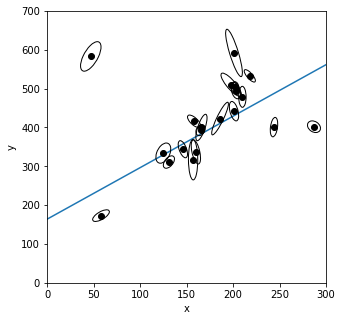

In [28]:
def ilnlike(theta, x, y, xerr, yerr, rhoxy):
    lnl = -lnlike2(theta.squeeze(), x, y, xerr, yerr, rhoxy)
    return lnl.squeeze()

th = thFromM(mFreq)
bp = bpFromBth(bFreq, th)
guess0 = np.array([th, bp])

scFit = minimize(ilnlike, guess0, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy))
print(scFit.message)
mSci = mFromTh(scFit.x[0])
bSci = bFromThBp(scFit.x[0], scFit.x[1])
print("The best-fit value for the slope and intercept are: {:.4f} and {:.4f}".format(mSci, bSci))

f, ax = plt.subplots(1, figsize = (5,5))
plotData(ax, obs_x, obs_y, sigma_x, sigma_y, rho_xy)
ax.plot( [0.,700.], mSci*np.array([0.,700.]) + bSci, color='C0')
ax.set_xlim(0,300)
ax.set_ylim(0,700)
ax.set_xlabel('x')
ax.set_ylabel('y')

Clearly this result is different from what we found before, and again we see the ominous warning from scipy.

Given just this data set, without knowing which are "outliers", how could we verify this fit and deal with what we may think "by eye" are outliers?

We could try some type of sigma clipping algorithm.  This is very popular, but also rather subjective.  We don't want to introduce unnecesary biases into our fit.  So we want to ***avoid sigma clipping***.  

Instead we will develop a new likelihood function that will deal with these outliers.  Here is where the Bayesian approach really begins to shine...

# MAKE THIS WORK

In [37]:

#incorporates intrinsic scatter
def lnlikeO(theta, x, y, xerr, yerr, rhoxy):
    th, bperp, p_b, v_b,delta_b = theta
    p_b = np.clip(p_b, 0, 1)                 # prevent errors in likelihood eval
    v_b = np.clip(v_b, 0, 2000**2)           # prevent errors in likelihood eval
    lnl = 0.
    v = np.array([[-np.sin(th)], [np.cos(th)]])
    vT = v.transpose()
    for (xx, yy, sx, sy, rxy) in zip(x, y, xerr, yerr, rhoxy):
        S = np.array([[ sx**2, rxy*sx*sy],
                    [rxy*sx*sy, sy**2.]]) 
        Z = np.array([[xx],[yy]])
        Delta = vT @ Z - bperp
        Sigma2 = vT @ S @ v
        
        lnl += np.log([(1 - p_b)/np.sqrt(2*np.pi*Sigma2)*np.exp(-Delta**2/(2*Sigma2)) + 
                       (p_b)/np.sqrt(2*np.pi*(Sigma2 + v_b))*np.exp(-(Delta - delta_b)**2/(2*(Sigma2 + v_b)))] )
        
        
        
    return lnl#.squeeze()

def lnpriorO(theta):
    th, bperp, p_b, v_b, delta_b = theta
    if ( (0 < np.abs(th) < 2.*np.pi) and (-200 < bperp < 200) and (0 <= v_b < 2000**2)
        and (0 < p_b < 1) and (-2000 < delta_b < 2000)):
        return 0.0
    return -np.inf

def lnprobO(theta, x, y, xerr, yerr, rhoxy):
    lnp = lnpriorO(theta)
    lnl = lnlikeO(theta,  x, y, xerr, yerr, rhoxy)
    if (not np.isfinite(lnp) or not np.isfinite(lnl)):
        return -np.inf
    return lnp + lnl

In [38]:
nwalkers = 100
nfac = [1e-2, 1e-2, 1e-2, 100, 10]
th = thFromM(mFreq)
bp = bpFromBth(bFreq, th)
guess0 = np.array([th, bp, 0.2, 1000., 0])
ndim = len(guess0)
pos = [guess0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobO, args=(obs_x, obs_y, sigma_x, sigma_y, rho_xy), threads = ncores)

nsamples = 2000
foo = sampler.run_mcmc(pos, nsamples)

/Users/ageller/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log


In [39]:
nburn = 500
th_samples = np.array(sampler.chain[:,nburn:,0]).flatten()
bp_samples = np.array(sampler.chain[:,nburn:,1]).flatten()
m_samples = mFromTh(th_samples)
b_samples = bFromThBp(th_samples, bp_samples)

#print the results taking 1-sigma confidence intervals
samples = np.vstack([m_samples, b_samples]).T
m_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      m = {:.4f} +{:.4f} -{:.4f}\n \
      b = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(m_mcmc[0], m_mcmc[1], m_mcmc[2], b_mcmc[0], b_mcmc[1], b_mcmc[2]))

emcee results with 1-sigma uncertainties
       m = 2.2778 +0.1377 -0.1210
       b = 24.3454 +19.7654 -22.3229



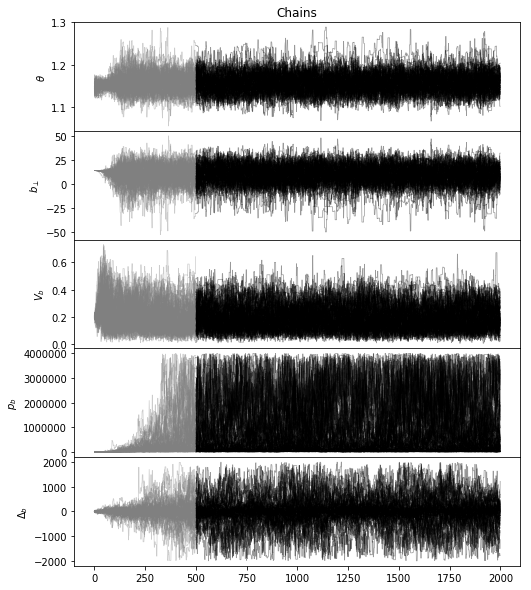

In [40]:
paramsNames = [r'$\theta$', r'$b_\perp$', r'$V_b$', r'$p_{b}$', r'$\Delta_b$']
    
#chain plot
axC = plotChains(sampler, nburn, paramsNames)

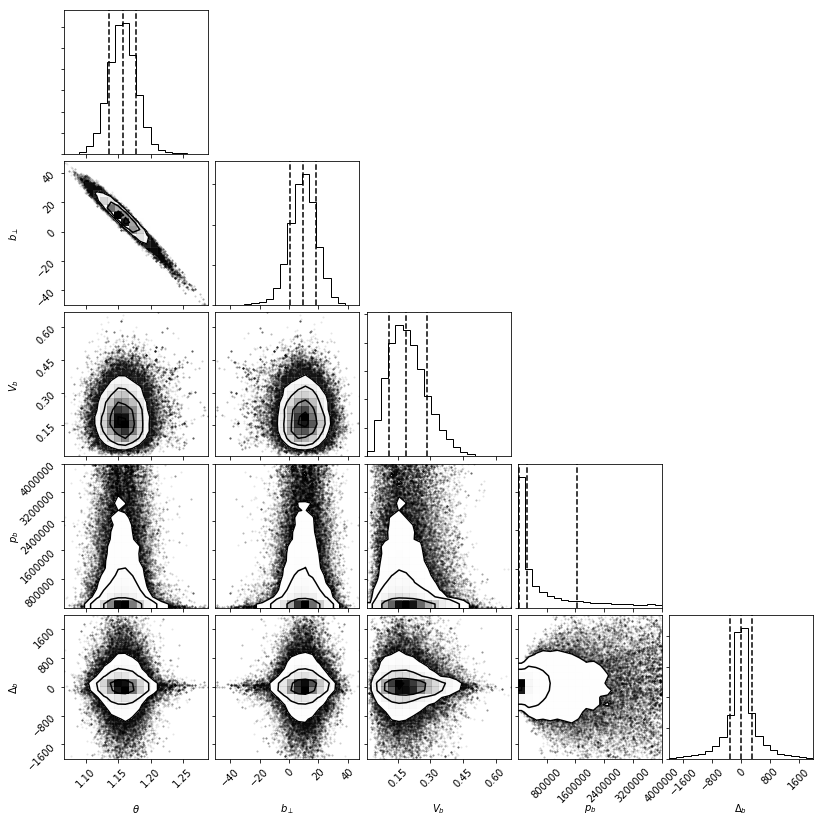

In [41]:
#corner plot
makeCorner(sampler, nburn, paramsNames)

[]


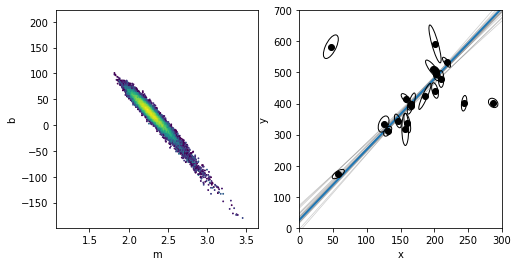

In [42]:
#Adam's plots
fac = 10.
axA = prettyPlot(obs_x, obs_y, sigma_x, sigma_y, rho_xy, m_samples, b_samples, m_mcmc[0], b_mcmc[0], nburn, ndraw = 20, \
                 extent = [m_mcmc[0] - fac*m_mcmc[2], m_mcmc[0] + fac*m_mcmc[1], b_mcmc[0] - fac*b_mcmc[2], b_mcmc[0] + fac*b_mcmc[1]])
axA[0].set_xlim(m_mcmc[0] - fac*m_mcmc[2], m_mcmc[0] + fac*m_mcmc[1])
axA[0].set_ylim(b_mcmc[0] - fac*b_mcmc[2], b_mcmc[0] + fac*b_mcmc[1])
axA[1].set_xlim(0,300)
axA[1].set_ylim(0,700)

#let's say that if mean(q) < 0.5, then we call it an outlier
sample = sampler.chain[:, nburn:, :].reshape(-1, ndim)
q = np.mean(sample[:, 7:], 0)
outliers = (q < 0.5)
print(q)
axA[1].plot(obs_x[outliers], obs_y[outliers], 'rx', ms=20)

# Now let's work with real data

I pulled Table 1 from [this paper on the "M-$\sigma$" relation](http://adsabs.harvard.edu/abs/2009ApJ...698..198G)

I will use *pandas* to read in and reformat the data, but feel free to do this instead with your own favorite method.

In [43]:
import pandas as pd
from IPython.display import display

In [44]:
#data from : http://adsabs.harvard.edu/abs/2009ApJ...698..198G
#They find log(MBH/M) = α + β log(σ/200 km s−1) with (α,β,0) = (8.12 ± 0.08, 4.24 ± 0.41, 0.44 ± 0.06) 
#But they include some with upper limits that I don't have here
mSigma = pd.read_csv('apj303542t1_ascii.txt', quotechar='"', sep='\t')
#print(mSigma.columns.values)
display(mSigma)

def fixSci(series):
    x = series.str.split(' ', expand = True)
    x2 = x[:][2].str.split('^', expand = True)
    return(x[:][0].astype("float") * 10.**x2[:][1].astype("float"))

def fixSig(series):
    x = series.str.split(' ', expand = True)
    return(x[:][0].astype("float"))
def fixSige(series):
    x = series.str.split(' ', expand = True)
    x2 = x[:][2].str.split('^', expand = True)
    return(x2[:][0].astype("float"))


obs_x = np.array(fixSig(mSigma['sigma_e (km s^-1)']))
obs_lx = np.log10(obs_x)
sigma_lx = 1./(obs_x * np.log(10.)) * np.array(fixSige(mSigma['sigma_e (km s^-1)']))

obs_y = np.array(fixSci(mSigma['M_BH (M_sun)']))
obs_ly = np.log10(obs_y)

#this is probably not what we would want for publication, but we can first try to take a mean uncertainty in x
y_low = np.array(fixSci(mSigma['M_low (M_sun)']))
y_high = np.array(fixSci(mSigma['M_high (M_sun)']))
ye_low = obs_y - y_low
ye_high = y_high - obs_y
ye = np.array([ (y1 + y2)/2. for (y1, y2) in zip(ye_low, ye_high)])
sigma_ly = 1./(obs_y * np.log(10.)) * ye

rho_lxy = np.full_like(obs_x, 0.0)



,Galaxy,Type^a,Dist. (Mpc),M_BH (M_sun),M_low (M_sun),M_high (M_sun),"Method, Ref.",sigma_e (km s^-1),"M^0_V,T","M^0_V,bulge^b",R_infl/d_res,Samp.,Unnamed: 12
0,"Circinus^c,^d",Sb,4.000,1.7 x 10^6,1.4 x 10^6,2.1 x 10^6,"Maser, 1",158 +or- 18^d,-17.36,...,6.06,S,NaN
1,IC1459^e,E4,30.900,2.8 x 10^9,1.6 x 10^9,3.9 x 10^9,"Stars, 2",340 +or- 17,-22.57,-22.57 +or- 0.15,0.56,S,NaN
2,"MW^f,^g",Sbc,0.008,4.1 x 10^6,3.5 x 10^6,4.7 x 10^6,"Stars, 3",105 +or- 20,...,...,20622.00,S,NaN
3,N0221 M32,E2,0.860,3.1 x 10^6,2.5 x 10^6,3.7 x 10^6,"Stars, 4",75 +or- 3,-16.83,-16.83 +or- 0.05,12.20,RS,NaN
4,N0224 M31,Sb,0.800,1.5 x 10^8,1.2 x 10^8,2.4 x 10^8,"Stars, 5",160 +or- 8,-21.84,...,113.00,S,NaN
5,N0821^h,E4,25.500,4.2 x 10^7,3.4 x 10^7,7.0 x 10^7,"Stars, 6",209 +or- 10,-21.24,-21.24 +or- 0.13,0.33,S,NaN
6,N1023,SB0,12.100,4.6 x 10^7,4.1 x 10^7,5.1 x 10^7,"Stars, 7",205 +or- 10,-21.26,-20.61 +or- 0.28,0.81,S,NaN
7,"N1068^g,^i M77",Sb,15.400,8.6 x 10^6,8.3 x 10^6,8.9 x 10^6,"Maser, 8",151 +or- 7,-22.17,...,22.50,S,NaN
8,N1300^g,SB(rs)bc,20.100,7.1 x 10^7,3.6 x 10^7,1.4 x 10^8,"Gas, 9",218 +or- 10,-21.34,...,0.65,S,NaN
9,N1399^j,E1,21.100,5.1 x 10^8,4.4 x 10^8,5.8 x 10^8,"Stars, 10",337 +or- 16,-22.13,-22.13 +or- 0.10,1.82,S,NaN


## Exercise:

Plot these data ("$x$" is $\log_{10}\sigma$,  and "$y$" is $\log_{10} M$).  Then run the data through *emcee*, using the likelihood that accounts for intrinsic scatter.  Print and plot the results.

Text(0,0.5,'$\\log_{10} M$')

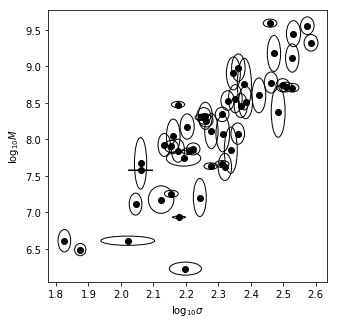

In [45]:
f, ax = plt.subplots(1, figsize = (5,5))
#ax.errorbar(obs_lx, obs_ly, xerr = sigma_lx, yerr = sigma_ly, fmt = "o", capsize=3)
plotData(ax, obs_lx, obs_ly, sigma_lx, sigma_ly, rho_lxy)
ax.set_xlabel(r'$\log_{10} \sigma$')
ax.set_ylabel(r'$\log_{10} M$')

In [46]:
nwalkers = 100
nfac = [1e-2, 1e-2, 1e-2]
th = thFromM(4.)
bp = bpFromBth(8., th)
guess0 = np.array([th, bp, 1.])
ndim = len(guess0)
pos = [guess0 + nfac * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobS, args=(obs_lx, obs_ly, sigma_lx, sigma_ly, rho_lxy), threads = ncores)

nsamples = 2000
foo = sampler.run_mcmc(pos, nsamples)

In [47]:
# set a "burn-in" limit
nburn = 200
th_samples = np.array(sampler.chain[:,nburn:,0]).flatten()
bp_samples = np.array(sampler.chain[:,nburn:,1]).flatten()
s_samples = np.array(sampler.chain[:,nburn:,2]).flatten()
m_samples = mFromTh(th_samples)
b_samples = bFromThBp(th_samples, bp_samples)

#print the results taking 1-sigma confidence intervals
samples = np.vstack([m_samples, b_samples, s_samples]).T
m_mcmc, b_mcmc, s_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0)))
print("emcee results with 1-sigma uncertainties\n \
      m = {:.4f} +{:.4f} -{:.4f}\n \
      b = {:.4f} +{:.4f} -{:.4f}\n \
      s = {:.4f} +{:.4f} -{:.4f}\n" \
      .format(m_mcmc[0], m_mcmc[1], m_mcmc[2], b_mcmc[0], b_mcmc[1], b_mcmc[2], s_mcmc[0], s_mcmc[1], s_mcmc[2]))

emcee results with 1-sigma uncertainties
       m = 5.4892 +0.5491 -0.4623
       b = -4.4156 +1.0564 -1.2550
       s = 0.0857 +0.0113 -0.0096



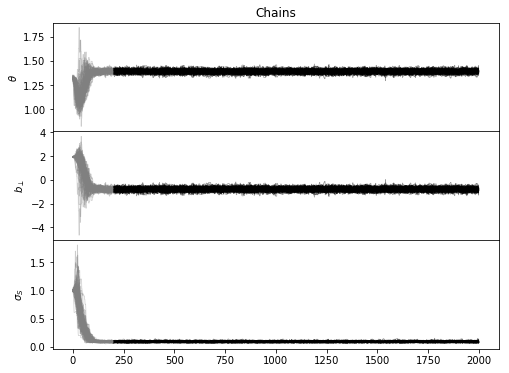

In [48]:
paramsNames = [r'$\theta$', r'$b_\perp$', r'$\sigma_S$']

#chain plot
axC = plotChains(sampler, nburn, paramsNames)

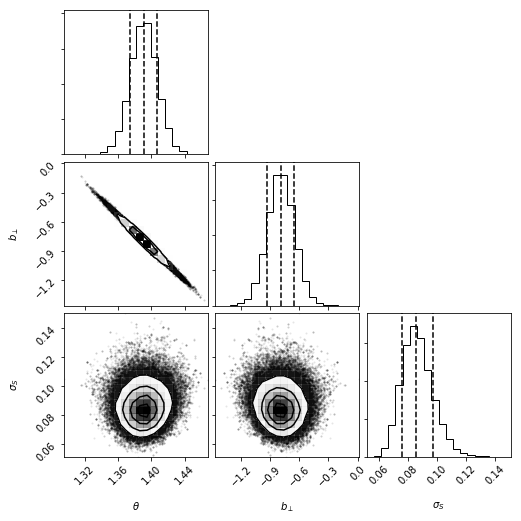

In [49]:
#corner plot
makeCorner(sampler, nburn, paramsNames)

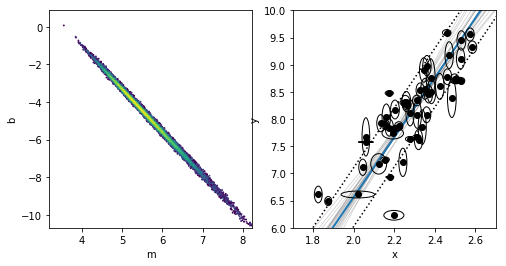

In [50]:
#Adam's plots
fac = 5.
axA = prettyPlot(obs_lx, obs_ly, sigma_lx, sigma_ly, rho_lxy, m_samples, b_samples, m_mcmc[0], b_mcmc[0], nburn, ndraw = 20, \
        extent = [m_mcmc[0] - fac*m_mcmc[2], m_mcmc[0] + fac*m_mcmc[1], b_mcmc[0] - fac*b_mcmc[2], b_mcmc[0] + fac*b_mcmc[1]])
axA[0].set_xlim(m_mcmc[0] - fac*m_mcmc[2], m_mcmc[0] + fac*m_mcmc[1])
axA[0].set_ylim(b_mcmc[0] - fac*b_mcmc[2], b_mcmc[0] + fac*b_mcmc[1])
axA[1].set_xlim(1.7,2.7)
axA[1].set_ylim(6,10)

smax = s_mcmc[0] + s_mcmc[1]
x0 = -b_mcmc[0]/m_mcmc[0] #x intercept
beta = np.arctan2(x0, b_mcmc[0]) #angle between line and y axis
alpha = np.pi/2. - beta #angle between perpendicular offset (s) and line
d = smax / np.cos(alpha) #distance to perpendicular offset in y direction
axA[1].plot([-1e10,1e10], [d + b_mcmc[0] + -1e10*m_mcmc[0], d + b_mcmc[0] + 1e10*m_mcmc[0]], ':k')
axA[1].plot([-1e10,1e10], [-d + b_mcmc[0] + -1e10*m_mcmc[0], -d + b_mcmc[0] + 1e10*m_mcmc[0]], ':k')